## Non-holonomic RRT 

In [1]:
import typing as ty
import tqdm.auto as tqdm

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as ptc

In [2]:
class Obstacle:

    def __init__(self, x: float, y: float, shape: ty.Union[ty.Tuple[str], ty.Tuple[str, float], ty.Tuple[str, float, float]]):
        self.x = x
        self.y = y
        self.shape = shape

    def render(self, ax):
        if self.shape[0] == "Rectangle":
            _, width, height = self.shape
            rect = plt.Rectangle((self.x - width / 2, self.y - height / 2), width, height, linewidth=1, color='r')
            ax.add_patch(rect)
        elif self.shape[0] == "Point":
            ax.plot(self.x, self.y, 'r*', markersize=20)
        elif self.shape[0] == "Circle":
            _, radius = self.shape
            circle = plt.Circle((self.x, self.y), radius, color='r')
            ax.add_patch(circle)

    @classmethod
    def rectangular_obstacle_from_vertices(cls, v1: ty.Tuple[float, float], v2: ty.Tuple[float, float], v3: ty.Tuple[float, float], v4: ty.Tuple[float, float]):
        x_max = max(v1[0], v2[0], v3[0], v4[0])
        y_max = max(v1[1], v2[1], v3[1], v4[1])
        x_min = min(v1[0], v2[0], v3[0], v4[0])
        y_min = min(v1[1], v2[1], v3[1], v4[1])
        return cls((x_max + x_min) / 2, (y_max + y_min) / 2, ("Rectangle", x_max - x_min, y_max - y_min))
        
    @classmethod
    def circular_obstacle_from_position_radius(cls, center: ty.Tuple[float, float], radius: float):
        return cls(center[0], center[1], ("Circle", radius))

    def __str__(self):
        return f"[Obstacle with center at position x={self.x} and y={self.y}, with shape={self.shape}]"

    def __repr__(self):
        return str(self)


class Pose:

    def __init__(self, x: float, y: float, theta: float):
        self.x = x
        self.y = y
        self.theta = theta

    def render(self, ax, color: str = 'g'):
        ax.plot(self.x, self.y, f'{color}*', markersize=20)

    @property
    def vector(self):
        return np.array([self.x, self.y, self.theta])

    def __str__(self):
        return f"[Robot Pose with position x={self.x}, y={self.y} and theta={self.theta}]"

    def __repr__(self):
        return str(self)

    def collides(self, obstacle: Obstacle):
        if obstacle.shape[0] == "Circle":
            return (self.x - obstacle.x) ** 2 + (self.y - obstacle.y) ** 2 < (obstacle.shape[1] * 1.4) ** 2
        elif obstacle.shape[0] == "Rectangle":
            return (abs(self.x - obstacle.x) < (obstacle.shape[1] * 1.4) / 2) and (abs(self.y - obstacle.y) < (obstacle.shape[2] * 1.4) / 2)
        elif obstacle.shape[1] == "Point":
            return False
        raise NotImplementedError("This shape is not recognised.")

    def distance(self, other_pose):
        return np.sqrt((self.x - other_pose.x) ** 2 + (self.y - other_pose.y) ** 2)
        

class Control:

    def __init__(self, v: float, w: float):
        self.v = v
        self.w = w

    @classmethod
    def from_wheel_velocities(cls, vl, vr, wheel_distance):
        v = (vl + vr) / 2
        w = (vr - vl) / (2 * wheel_distance)
        return cls(v, w)

    def transform(self, time: float, pose: Pose):
        x = (self.v / self.w) * np.sin(self.w * time)
        y = - (self.v / self.w) * (1 - np.cos(self.w * time))
        theta = self.w * time
        pos = np.array([
            [np.cos(pose.theta), np.sin(pose.theta)],
            [-np.sin(pose.theta), np.cos(pose.theta)],
        ]) @ np.array([[x], [y]])
        pos = pos.reshape(-1)
        return Pose(pose.x + pos[0], pose.y + pos[1], pose.theta + theta)

    def render(self, ax: plt.Axes, time: float, pose: Pose, color='k'):
        radius = self.v / self.w
        center = (
            np.array([
                [np.cos(pose.theta), np.sin(pose.theta)],
                [-np.sin(pose.theta), np.cos(pose.theta)],
            ]) @ np.array([[0], [-radius]])
        ).reshape(-1)
        ax.add_patch(
            ptc.Arc(
                center + np.array([pose.x, pose.y]),
                radius * 2,
                radius * 2,
                0,
                90.0 - (pose.theta * 180 / np.pi) + min(0.0, -self.w * time * 180 / np.pi), 
                90.0 - (pose.theta * 180 / np.pi) + max(0.0, -self.w * time * 180 / np.pi),
                color=color,
            )
        )

    def __str__(self):
        return f"[Robot Control action with v={self.v} and w={self.w}]"

    def __repr__(self):
        return str(self)


class Environment:

    def __init__(self, obstacles: ty.List[Obstacle], starting_pose: Pose, target_pose: Pose):
        self.obstacles = obstacles
        self.starting_pose = starting_pose
        self.target_pose = target_pose
    
    def render(self, ax):
        plt.xlim(-10, 110)
        plt.ylim(-10, 110)
        for obstacle in self.obstacles:
            obstacle.render(ax=ax)
        self.starting_pose.render(ax=ax, color='b')
        self.target_pose.render(ax=ax, color='g')
        ax.set_aspect('equal', adjustable='box')

    def valid_pose(self, pose: Pose):
        if not (-2 <= pose.x and pose.x <= 102 and -2 <= pose.y and pose.y <= 102):
            return False
        for obstacle in self.obstacles:
            if pose.collides(obstacle):
                return False
        return True

In [3]:
env_default = Environment(
    obstacles = [
        Obstacle.rectangular_obstacle_from_vertices((40, 62), (40, 100), (60, 100), (60, 62)),
        Obstacle.rectangular_obstacle_from_vertices((70, 40), (70, 60), (80, 60), (80, 40)),
        Obstacle.rectangular_obstacle_from_vertices((40, 0), (40, 38), (60, 38), (60, 0)),
        Obstacle.circular_obstacle_from_position_radius((20, 20), 7),
        Obstacle.circular_obstacle_from_position_radius((90, 70), 2),
        Obstacle.circular_obstacle_from_position_radius((77, 82), 3),
    ],
    starting_pose = Pose(0, 1, 0),
    target_pose = Pose(100, 100, 0),
)

env_custom = Environment(
    obstacles = [
        Obstacle.rectangular_obstacle_from_vertices((20, 50), (20, 90), (40, 90), (40, 50)),
        Obstacle.rectangular_obstacle_from_vertices((70, 40), (70, 60), (80, 60), (80, 40)),
        Obstacle.rectangular_obstacle_from_vertices((40, 0), (40, 35), (60, 35), (60, 0)),
        Obstacle.circular_obstacle_from_position_radius((60, 70), 7),
        Obstacle.circular_obstacle_from_position_radius((80, 80), 5),
        Obstacle.circular_obstacle_from_position_radius((50, 50), 5),
    ],
    starting_pose = Pose(0, 1, 0),
    target_pose = Pose(75, 70, 0),
)

chosen_environment = input("Enter the environment to run on (default/custom)")
env = env_custom if 'c' in chosen_environment else env_default

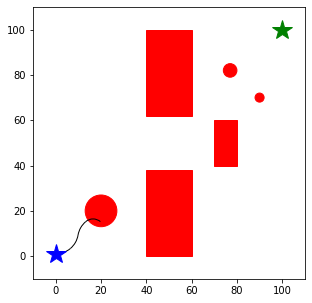

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
env.render(ax)
pose = env.starting_pose
for control in [Control(10, -1), Control(10, -1), Control(10, 1), Control(10, 2)]:
    control.render(ax, 0.7, pose)
    pose = control.transform(0.7, pose)
    # pose.render(ax, 'k')
plt.show()

100%|██████████| 10000/10000 [01:36<00:00, 103.93it/s]


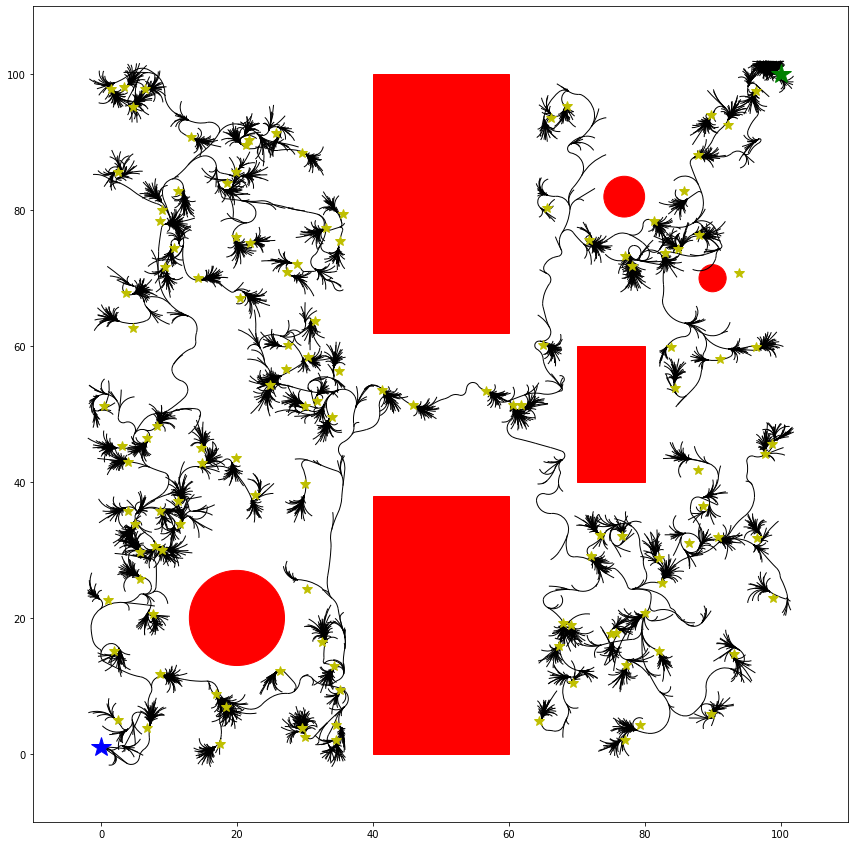

In [5]:
class RRTSearch:

    def __init__(self, env):
        self.env = env
        self.poses = [env.starting_pose]
        self.controls = [None]
        self.parents = [None]
        self.time = 1.0
        self.pseudo_goals = list(filter(env.valid_pose, [Pose(np.random.random() * 100, np.random.random() * 100, 0) for i in range(200)]))

    def sample_node(self):
        selected_target = np.random.choice(
            [env.target_pose] + self.pseudo_goals, 
            p=[(0.2 if i == 0 else 0.8 / len(self.pseudo_goals)) for i in range(len(self.pseudo_goals) + 1)]
        )
        d = np.array([pose.distance(selected_target) for pose in self.poses])
        # d = (1 / d) ** 1.5
        # d = d / np.sum(d)
        c = np.argmin(d)  # np.random.choice(np.arange(len(self.poses)), p=d)
        return c

    def sample_control(self):
        return Control(np.clip(np.random.normal(2, 1), 0.5, 10.0), np.random.normal(0, 1))

    def extend_node(self, idx):
        control = self.sample_control()
        pose = control.transform(self.time, self.poses[idx])
        if env.valid_pose(pose):
            self.poses.append(pose)
            self.controls.append(control)
            self.parents.append(idx)

    def compute(self, steps=5000):
        for _i in tqdm.trange(steps):
            self.extend_node(self.sample_node())

    def render(self):
        _fig, ax = plt.subplots(figsize=(15, 15))
        env.render(ax)
        for item in self.pseudo_goals:
            ax.plot(item.x, item.y, 'y*', markersize=10)
        for idx in range(1, len(self.controls)):
            self.controls[idx].render(ax, self.time, self.poses[self.parents[idx]])
        plt.show()

    def path(self):
        d = np.array([pose.distance(env.target_pose) for pose in self.poses])
        index = np.argmin(d)
        path = []
        while index != None:
            path.append(index)
            index = self.parents[index]
        return list(reversed(path))


np.random.seed(10)
rrt = RRTSearch(env)
rrt.compute(10000)
rrt.render()

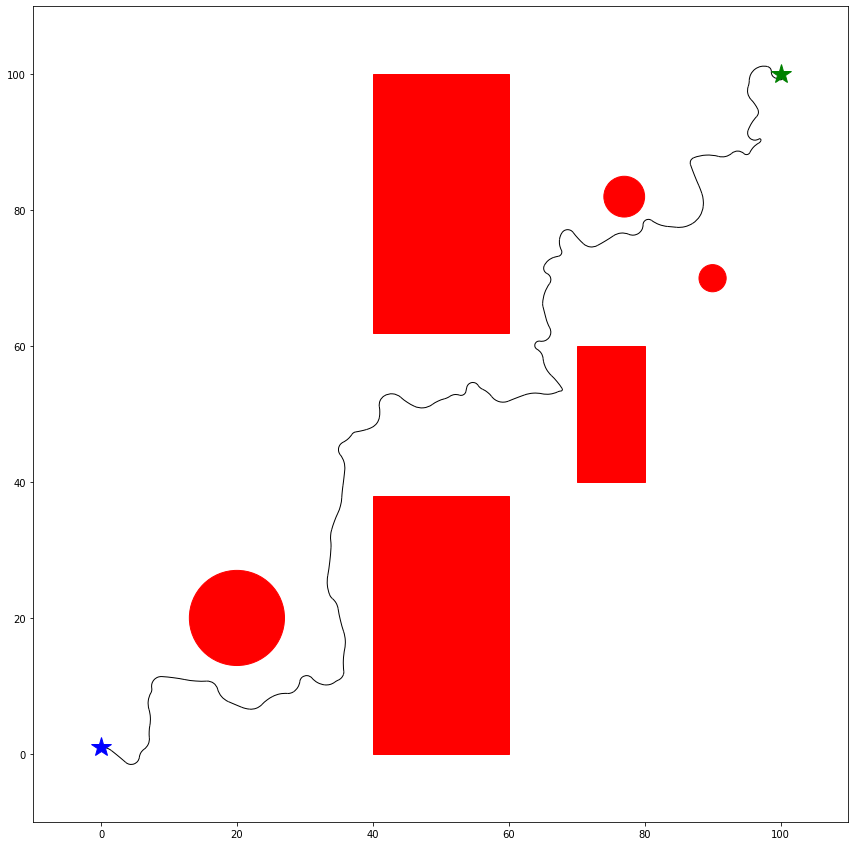

In [6]:
path = rrt.path()

fig, ax = plt.subplots(figsize=(15, 15))
env.render(ax)
for iteration, idx in enumerate(path[1:]):
    rrt.controls[idx].render(ax, rrt.time, rrt.poses[rrt.parents[idx]])
plt.show()

In [7]:
class NonHolonomicRRT:

    def __init__(self, env, rrt):
        self.env = env
        self.rrt = rrt
        self.name = f"barrow_{chosen_environment}"

    def show_path(self):
        """
        Create a new directory (say non_holonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        path = rrt.path()
        fig, ax = plt.subplots(figsize=(15, 15))
        env.render(ax)
        for iteration, idx in tqdm.tqdm(enumerate(path[1:])):
            rrt.controls[idx].render(ax, rrt.time, rrt.poses[rrt.parents[idx]])
            fig.savefig(f"videos/path_{self.name}/snap_{iteration}.png")
        
    def show_tree(self):
        """
        Create a new directory (say non_holonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        fig, ax = plt.subplots(figsize=(15, 15))
        self.env.render(ax)
        counter = 0
        for idx in tqdm.trange(1, len(self.rrt.controls)):
            self.rrt.controls[idx].render(ax, self.rrt.time, self.rrt.poses[self.rrt.parents[idx]])
            if (idx + 1) % 100 == 0:
                fig.savefig(f"videos/tree_{self.name}/snap_{counter}.png")
                counter += 1

    def visualize_wheels(self):
        """
        Given the list of platform centre velocities(v,w) visualize the trajectories of:
        1. platform centre
        2. left wheel
        3. right wheel
        Save the wheel trajectories in the same manner that we saved the snapshots of the RRT tree above.
        """
        path = rrt.path()
        fig, ax = plt.subplots(figsize=(15, 15))
        env.render(ax)
        b = 0.5
        for iteration, idx in tqdm.tqdm(enumerate(path[1:])):
            pose = rrt.poses[rrt.parents[idx]]
            l_pose = Pose(pose.x + b * np.sin(pose.theta), pose.y + b * np.cos(pose.theta), pose.theta)
            r_pose = Pose(pose.x - b * np.sin(pose.theta), pose.y - b * np.cos(pose.theta), pose.theta)
            control = rrt.controls[idx]
            radius = control.v / control.w
            l_control = Control(control.v * (abs(radius + b) / abs(radius)), control.w)
            r_control = Control(control.v * (abs(radius - b) / abs(radius)), control.w)
            l_control.render(ax, rrt.time, l_pose, color='green')
            r_control.render(ax, rrt.time, r_pose, color='blue')
            fig.savefig(f"videos/path_{self.name}/snap_{iteration}.png")
        plt.show()

100%|██████████| 8911/8911 [01:58<00:00, 75.32it/s] 
119it [00:17,  6.88it/s]


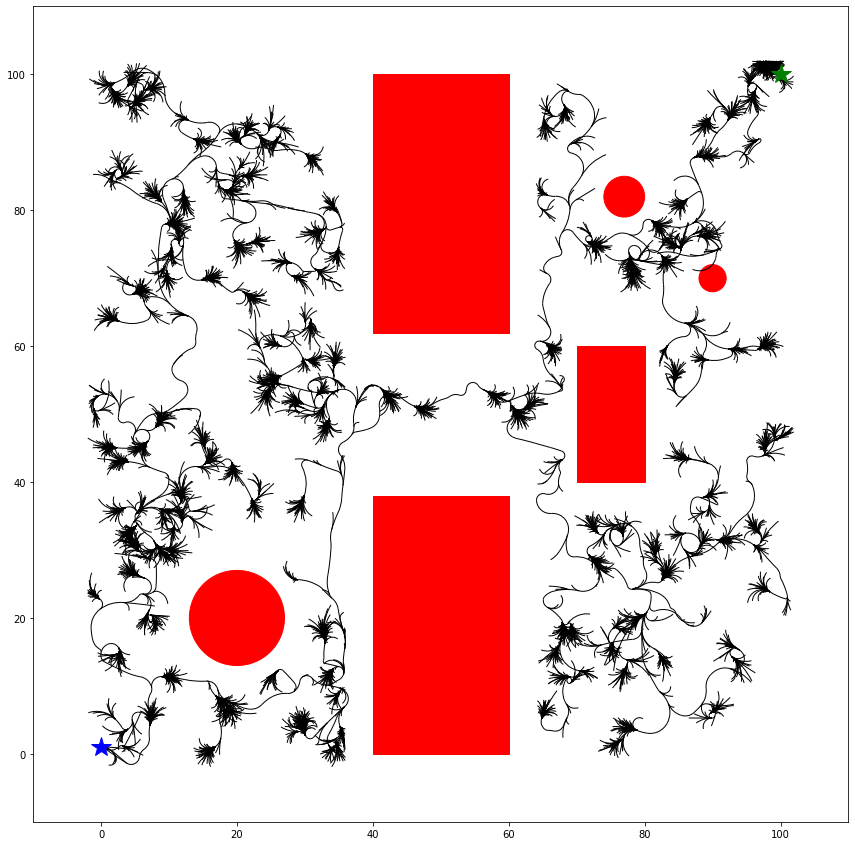

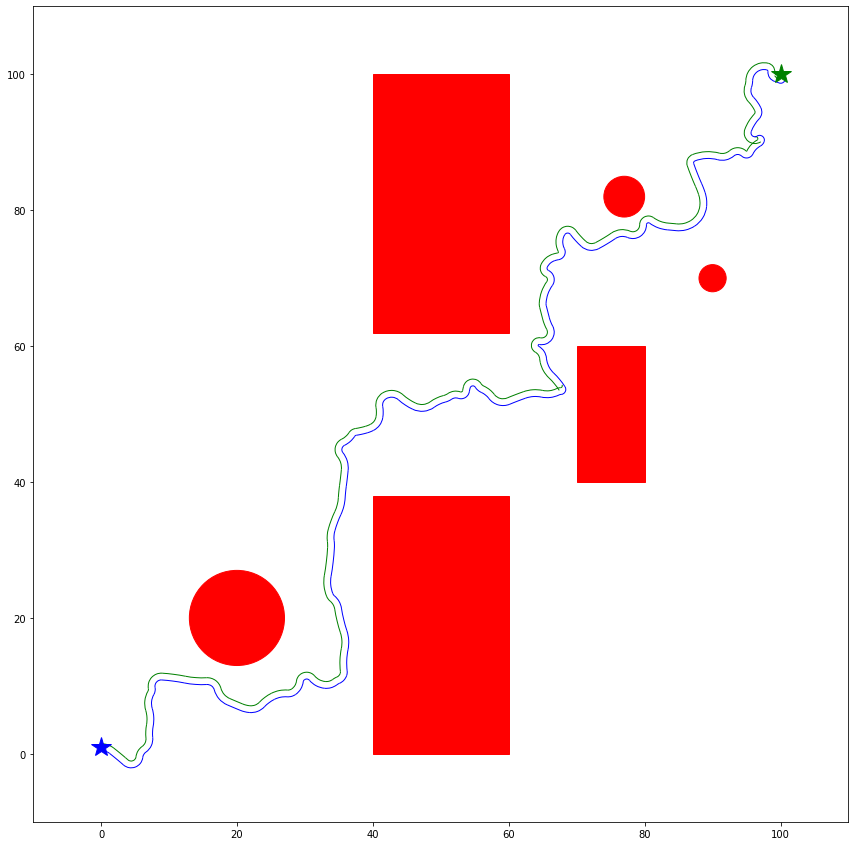

Result generation Completed


In [8]:
results = NonHolonomicRRT(env, rrt)
results.show_tree()
results.visualize_wheels()
print("Result generation Completed")